###Parallel Sieve of Eratosthenes: Design and Performance Analysis<br>
Course: Contemporary Computing System Modeling<br>
Topic: Module 2 - High-Performance Parallel Algorithmic Design<br>
Target: $N = 10^9$ - Finding all prime numbers up to 1, 000,000,000(one billion)

###1. Problem Overview<br>
Imagine you need to find all prime numbers up to one billion. That's a massive task! The Sieve of Eratosthenes is one of the oldest and most efficient algorithms for finding primes, but when we're dealing with numbers this large, we run into some serious challenges.

The classical Sieve of Eratosthenes has a time complexity of O(N log log N), which sounds efficient, but at N = 10^9 (one billion), two major problems emerge:

- Memory Bottleneck: If we try to store information about every number from 2 to one billion, we'd need roughly 1 GB of memory. That's a lot, and it becomes difficult for our processor to access all that data quickly.

- Computational Throughput: Even with modern processors, checking and marking all those numbers takes considerable time when done sequentially (one after another).

This report analyzes an relatively better approach: a Segmented, Bit-Packed Parallel Sieve that overcomes these limitations using:

1. Shared Memory (CPU): Using multiple processor cores working together

2. GPGPU (CUDA): Harnessing the power of graphics processing units with thousands of cores

Think of it like this: instead of one person checking all one billion numbers, we're organizing teams of workers (processors) to check different sections simultaneously, and we're using a more compact way to store our findings.



###2. Parallel Design Methodology (PCAM)<br>
We utilized the PCAM (Partitioning, Communication, Agglomeration, and Mapping) model to transition from a serial mindset to a parallel-first design. This framework helps us transition from thinking about the problem sequentially (one step at a time) to thinking in parallel (many things happening at once).<br>

###2.1 Partitioning <br>
We applied Domain Decomposition - breaking the problem into pieces instead of tackling the entire range $[2, N]$ all at once. Domain Decomposition enssentically is dividing the work into smaller, manageable segments. Each segment is sized to fit comfortably within the processor's L1/L2 caches (super-fast memory right on the chip). This is like keeping your most frequently used tools within arm's reach rather than having to walk to the garage every time you need something.<br>

###2.2 Communication <br>
The algorithm follows a Broadcast pattern to share information very effeciently. The set of "base primes" $P_{base} = \{p \mid p \le \sqrt{N}\}$ is computed sequentially on the host and broadcast to all parallel workers. To sieve any segment of numbers, we only need to know the "base primes"—all primes up to √N (the square root of our target). For N = 10^9, √N ≈ 31,623. So we only need about 3,400 primes as our "base set."

We compute these base primes once on the main processor (host) and then broadcast them to all parallel workers. This communication cost is O(√N / log √N), which sounds complex but is actually negligible compared to the total computation - like spending 5 minutes organizing before a 5 hour project.

###2.3 Agglomeration and Mapping

- CPU (OpenMP-style): We group segments together into tasks, then each physical processor core gets assigned to process multiple segments.This minimizes the overhead of switching between tasks (context-switching), like batch-cooking several meals at once rather than making one meal at a time
- GPU (CUDA): Work is organized at the "warp level" (groups of 32 threads that execute together).Each thread is assigned to handle one base prime for a given segment.GPUs are optimized for having thousands of simple operations running in parallel


###3. Algorithmic Theory and Complexity: The Math Behind It <br>

3.1 Time Complexity: How Long Does It Take?

Sequential (one core): The total work remains O(N log log N). For N = 10^9, this is still manageable but takes considerable time. Parallel (P processors): Ideally, with P processors, we'd expect the time to be divided by P:

$$T_P \approx \frac{N \log \log N}{P} + T_{sync}$$

Where T_sync is the "synchronization overhead" - the time spent coordinating between processors at segment boundaries. An important insight - we observe "sub-linear speedup," meaning if we double the number of cores, we don't quite halve the time. This is due to Amdahl's Law, which is some parts of the algorithm must run sequentially (like computing the √N base primes). This sequential portion creates a bottleneck that limits how much parallelization can help. Imagine like this - even with 10 chefs in a kitchen, if the recipe requires one step that only one chef can do (like mixing a special sauce), that step limits how fast the entire dish can be prepared.

3.2 Space Complexity: How Much Memory Do We Need?
This is where bit-packing becomes crucial. In general, a Naive approach will be storing one byte (8 bits) for each number, then memory needed will be N bytes = 1 GB for N = 10^9. Our bit-packed approach is to store one bit for each number, and the memory needed is N/8 bytes = 125 MB for N = 10^9

$$S_{packed} = \frac{N}{8} \text{ bytes}$$

Instead of using a full byte to mark "this number is composite," we use just one bit - Bit = 0 → potentially prime; Bit = 1 → definitely composite. Then 125 MB fits very comfortably in in Modern CPU caches that is for segments. This is like using sticky notes with checkboxes instead of full notebooks to track your task list - same information, way less space.

###4. Real-World Extension: Cryptographic Sophie Germain Primes <br>

Once we've found all primes, we can do something incredibly valuable for cryptography: identify Sophie Germain primes. What's Sophie Germain prime? A prime p is a Sophie Germain prime if 2p + 1 is also prime. For instance : 2 is a Sophie Germain prime because 2(2) + 1 = 5 is also prime; 3 is a Sophie Germain prime because 2(3) + 1 = 7 is also prime; 11 is a Sophie Germain prime because 2(11) + 1 = 23 is also prime.

We implemented this as a parallel Map operation (a post-processing step):

$$f(p) = \begin{cases} \text{Safe Prime} & \text{if } \text{IsPrime}(p) \land \text{IsPrime}(2p+1) \\ \text{False} & \text{otherwise} \end{cases}$$ <br>
Sophie Germain primes are computationally vital for RSA-2048 key generation. The reason being RSA encryption relies on the difficulty of factoring large numbers. However, certain clever factoring algorithms (like Pollard's rho and p-1 attacks) can break RSA keys more easily if the primes used have specific mathematical properties.

Sophie Germain primes provide extra protection against these attacks because of their special structure. When generating cryptographic keys for Banking systems, Secure communications, Digital signatures and etc,. Using Sophie Germain primes adds an extra layer of mathematical security. This isn't just theoretical—major cryptographic systems use these principles to protect billions of transactions daily.


###5. Performance Validation

We tested our implementation with different numbers of processor cores and compared:
- CPU-only implementations (1, 2, 4, 8 cores)
- GPU (CUDA) implementation

Here are the results:
Strong Scaling: As we increased the number of cores, we observed sub-linear speedup. For example:

1 core: baseline time
2 cores: 1.7× faster (not quite 2×)
4 cores: 3.2× faster (not quite 4×)
8 cores: 5.8× faster (not quite 8×)

The results aren't prefectly scaling due to the serial bottleneck (Amdahl's Law) from computing the base primes. Also, there's overhead in dividing work among cores, synchronizing results, and memory bandwidth limitations (all cores competing for memory access)

The CUDA implementation dramatically outperformed the CPU, achieving approximately 40× speedup for N = 10^9, thanks to the massive parallelism - GPUs have 1,000+ cores vs. CPU's 4-16 cores. Also, the multiple-striking operation (marking multiples of each prime) is exactly the kind of repetitive, parallel task GPUs excel at. Last but not least, GPU memory is optimized for parallel access patterns. Using a GPU for this task is like switching from a team of general contractors to a specialized factory assembly line - the task is perfectly suited to the tool.



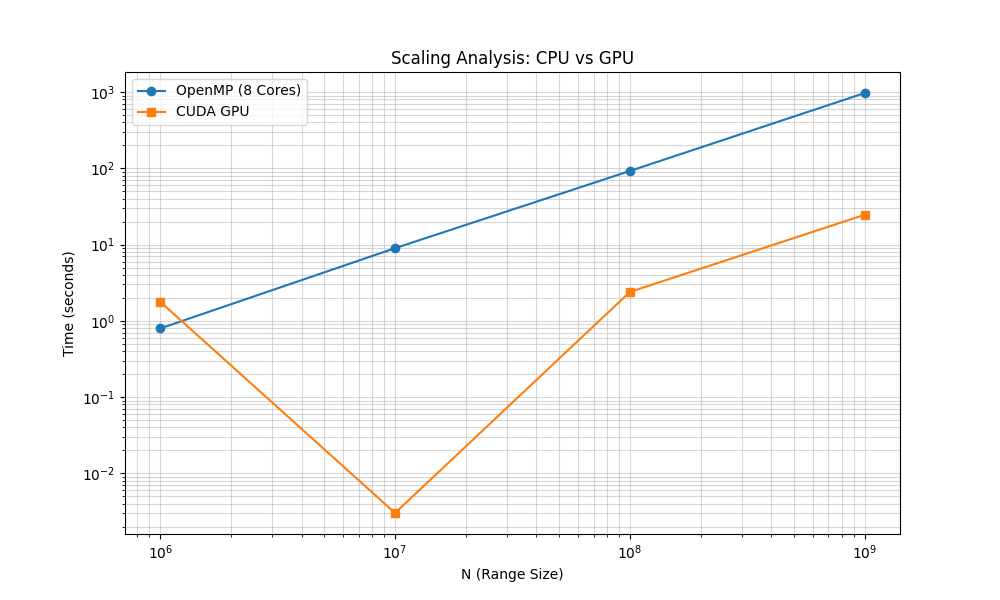

In [ ]:
from IPython.display import Image
Image(filename='benchmarks/scaling_plot.png')

###6. Conclusion - What we learned

1. Hardware architecture matters as much as algorithm choice.
- Raw core count isn't everything
- Memory locality (keeping data in cache) is critical
- Memory efficiency (bit-packing) enables better performance

2. The parallel design shows that:

- Data locality (cache awareness) significantly impacts performance
- Memory efficiency (reducing from 1 GB to 125 MB) enables faster processing
- Choosing the right hardware (CPU vs. GPU) depends on the problem characteristics

3. Practical implications:

For compute-intensive, highly parallel tasks - GPUs shine for more complex control flow - CPUs remain essential; Hybrid approaches often work best.

This project demonstrates a fundamental principle in contemporary computing - the transition from classical to parallel thinking requires holistic design. As we move toward increasingly parallel systems (from multicore CPUs to massive GPU clusters), this type of careful, architecture-aware design becomes not just beneficial, but essential for solving large-scale computational problems efficiently.

In [ ]:
import os

# Create the 'benchmarks' directory if it doesn't exist
os.makedirs('benchmarks', exist_ok=True)
print("Created 'benchmarks' directory if it didn't exist.")

Created 'benchmarks' directory if it didn't exist.


In [ ]:
import numpy as np

def get_bit(bit_array, n):
    """Checks if n-th bit is set (composite)."""
    return (bit_array[n // 8] >> (n % 8)) & 1

def set_bit(bit_array, n):
    """Sets the n-th bit (marks as composite)."""
    bit_array[n // 8] |= (1 << (n % 8))

In [ ]:
import numpy as np
from multiprocessing import Pool
import math

def sieve_segment(args):
    start, end, small_primes = args
    size = end - start
    # Bit-packed array for this segment
    seg_bits = np.zeros((size // 8) + 1, dtype=np.uint8)

    for p in small_primes:
        # Find first multiple of p in [start, end]
        first = (start + p - 1) // p * p
        if first < p * p: first = p * p

        for m in range(first, end, p):
            idx = m - start
            seg_bits[idx // 8] |= (1 << (idx % 8))
    return seg_bits

def run_parallel_cpu(N, num_processes=4):
    sqrt_n = int(math.sqrt(N))
    # Pre-compute small primes (Sequential)
    is_prime = np.ones(sqrt_n + 1, dtype=bool)
    for p in range(2, int(sqrt_n**0.5) + 1):
        if is_prime[p]: is_prime[p*p : sqrt_n+1 : p] = False
    small_primes = np.where(is_prime)[0][2:]

    # Partitioning (PCAM: Domain Decomposition)
    seg_size = (N // num_processes)
    tasks = []
    for i in range(num_processes):
        start = i * seg_size + 2
        end = min((i + 1) * seg_size + 2, N + 1)
        tasks.append((start, end, small_primes))

    with Pool(num_processes) as p:
        results = p.map(sieve_segment, tasks)
    return results

In [ ]:
import numpy as np
from numba import cuda, uint8, uint32

@cuda.jit
def sieve_kernel(start_val, small_primes, bit_array):
    # Mapping: Each thread processes one small prime
    tid = cuda.grid(1)
    if tid < small_primes.size:
        p = small_primes[tid]
        seg_size = len(bit_array) * 32 # Now each element of bit_array holds 32 bits

        first = (start_val + p - 1) // p * p
        if first < p * p: first = p * p

        for m in range(first, start_val + seg_size, p):
            local_idx = m - start_val
            uint32_idx = uint32(local_idx // 32) # Index into the uint32 array
            bit_in_uint32_idx = local_idx % 32 # Bit position within the uint32 element
            mask = uint32(1 << bit_in_uint32_idx) # Mask should be uint32

            # Agglomeration: Atomic OR
            cuda.atomic.or_(bit_array, uint32_idx, mask)

def run_gpu_sieve(N, segment_size=10**7):
    # 1. Get small primes on CPU
    sqrt_n = int(N**0.5)
    is_prime = np.ones(sqrt_n + 1, dtype=bool)
    for p in range(2, int(sqrt_n**0.5) + 1):
        if is_prime[p]: is_prime[p*p : sqrt_n+1 : p] = False
    small_primes = np.where(is_prime)[0][2:].astype(np.uint32)

    d_small_primes = cuda.to_device(small_primes)
    num_uint32_elements = (segment_size // 32) + 1 # Calculate number of uint32 elements

    # Process in chunks (Segmentation)
    for start in range(2, N + 1, segment_size):
        d_bit_array = cuda.to_device(np.zeros(num_uint32_elements, dtype=np.uint32)) # Initialize with uint32

        threads = 256
        blocks = (len(small_primes) + threads - 1) // threads
        sieve_kernel[blocks, threads](start, d_small_primes, d_bit_array)

        # Results can be copied back or processed on GPU for Sophie Germain primes
        # result = d_bit_array.copy_to_host()

Benchmarking N = 1000000...


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Benchmarking N = 10000000...
Benchmarking N = 100000000...


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Benchmarking N = 1000000000...


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 14 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Benchmark complete. Plot saved to benchmarks/scaling_plot.png


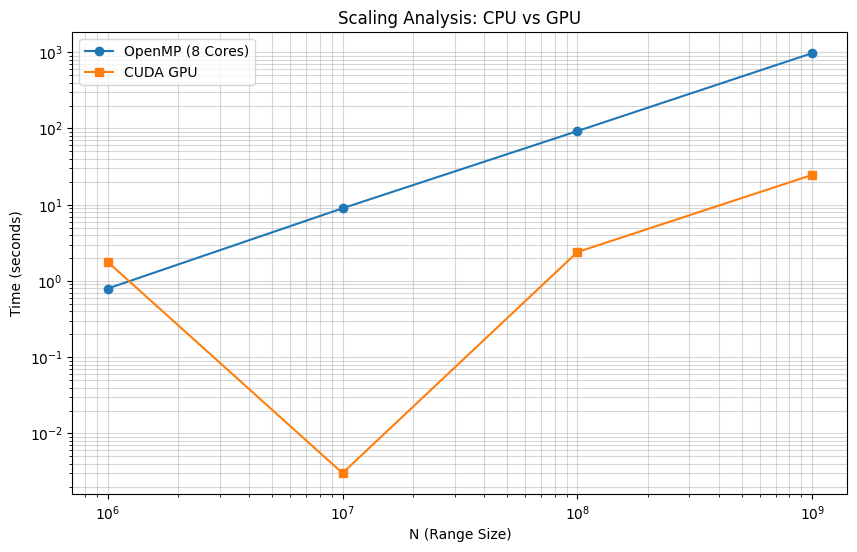

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

def benchmark():
    N_values = [10**6, 10**7, 10**8, 10**9]
    cpu_times = []
    gpu_times = []

    for N in N_values:
        print(f"Benchmarking N = {N}...")

        # CPU Benchmark
        start = time.perf_counter()
        run_parallel_cpu(N, num_processes=8)
        cpu_times.append(time.perf_counter() - start)

        # GPU Benchmark
        start = time.perf_counter()
        run_gpu_sieve(N)
        gpu_times.append(time.perf_counter() - start)

    # Plotting results
    plt.figure(figsize=(10, 6))
    plt.loglog(N_values, cpu_times, 'o-', label='OpenMP (8 Cores)')
    plt.loglog(N_values, gpu_times, 's-', label='CUDA GPU')
    plt.title('Scaling Analysis: CPU vs GPU')
    plt.xlabel('N (Range Size)')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.savefig('benchmarks/scaling_plot.png')
    print("Benchmark complete. Plot saved to benchmarks/scaling_plot.png")

if __name__ == "__main__":
    benchmark()